In [0]:
# instalación de opencv y skeleton
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

from scipy import ndimage
import numpy as np
from PIL import Image

import math
import matplotlib.pyplot as plt 

from skimage.io import imread, imshow
from skimage.filters import threshold_otsu
from skimage import io,color,util
from skimage.morphology import skeletonize,skeletonize_3d
from skimage.color import rgb2lab



In [4]:
from google.colab import files
uploaded=files.upload()

MessageError: ignored

In [5]:
ls


datalab/


Montar google drive como disco duro¿?¿?¿?
cARGAR IMAGENES en un zip(dropbox-github)
mirar eskeleton


In [0]:
#@title Default title text
from urllib import request

# cargando la imagen del articulo desde internet
url = "https://ars.els-cdn.com/content/image/1-s2.0-S0260877416303521-gr1_lrg.jpg"
path = "gambas.jpg"



f = open(path, 'wb')
f.write(request.urlopen(url).read())
f.close()

In [6]:
!ls

datalab  gambas.jpg


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


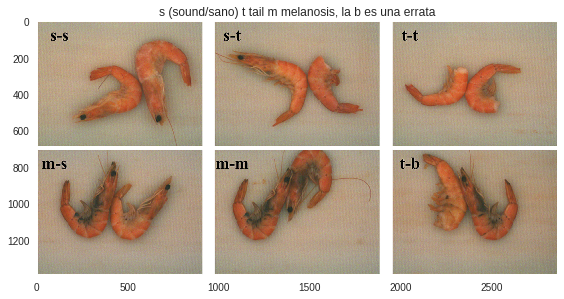

In [7]:
import matplotlib.pyplot as plt 
from skimage.io import imread, imshow

img = imread(path)

imshow(img)
plt.title('s (sound/sano) t tail m melanosis, la b es una errata')
plt.grid(False)
plt.show() 




In [8]:
!ls

datalab  gambas.jpg


Voy a empezar a probar los algoritmos del artículo.

Se hace extracción de características para clasificar la gamba en:
- sano
- cola
- melanosis
- desconocido


Esto se usa para clasificar como correctas o incorrectas las segmentaciones. 
Si un elemento se divide en dos partes y las dos partes pertenecen a los grupos conocidos la segmentación es buena, en caso contrario es erronea.

Características:
- Área. Puede facilmente diferenciar entre sano y cola
- Característica del ojo. En algunos casos el área de una cola puede ser similar al área de un sano pequeño. En estos casos se puede usar el ojo para discriminar. Esto se hace en 3 pasos:
  - Obtención del contorno y del esqueleto de la gamba. El esqueleto es el resultado de la operación de esqueletización.
  - Calcular el "área blanca" que curiosamente es negra ??. Una vez pasada a escala de grises, serían las zonas de la gamba con una intensidad menor de 50. Una vez eliminado el ruido.
  - Identificación del ojo dentro del "área blanca". El ojo está muy cercano al punto final del esqueleto. Se pueden obtener los centroides de las regiones de la zona blanca y obtener sus distancias euclideas con respecto a los puntos finales del esqueleto. La región con menor distancia euclidea será el ojo.
  
- Area Ratio: Ni el área, ni la presencia de ojo discrimina entre sanas y melanoticas. Quitando el ojo del "área blanca" tenemos el área de melanosis. $\text{area ratio} =\dfrac{\text{area melanosis}}{\text{area total}}$


Estas 3 características pueden discriminar los tipos de gamba de los fragmentos después de una segmentación.

In [10]:
# hacer ejemplo de selección con máscara

'''
Hacer selección con máscara significa que si tenemos un array de booleanos (por ejemplo el resultante de binarizar una imagen)
ponemos obtener una imagen en la que se seleccionen los pixels en los que en la mascara tenemos True y el resto de pixels se dejan a negro o blanco


'''

# primero el ejemplo de la documentación de binarización
from skimage import data
from skimage.filters import threshold_otsu
from skimage.io import imread, imshow

import matplotlib.pyplot as plt


image = data.camera()

path = '4.JPG' 

img=leer_mostrar_imagen(path)
#image=imagen_2D(img)

thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=2, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1)
ax[1] = plt.subplot(1, 2, 2, sharex=ax[0], sharey=ax[0])

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')


ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Thresholded')
ax[1].axis('off')

plt.show()




NameError: ignored

In [11]:
# Vemos que binary (la imagen en blanco y negro) es una mascara
binary

NameError: ignored

In [12]:
# Ejemplo de como funciona la selección usando máscara
import numpy as np

a = np.array([1,2,3,4,5,6,7,8,9,10])
b = np.array([False,False,False,False,False,True,True,True,True,True])

c = a.copy()
c[~b] = 0
c

array([ 0,  0,  0,  0,  0,  6,  7,  8,  9, 10])

In [13]:
# ejemplo que invierte la selección

c = a.copy()
c[b] = 0
c

array([1, 2, 3, 4, 5, 0, 0, 0, 0, 0])

In [0]:
# previamente a usar este ejemplo con una imagen hay que "aplanarla"
image.flatten()[binary.flatten()]

array([156, 157, 160, ..., 121, 113, 111], dtype=uint8)

In [0]:
# flatten aplana (pasa todo a una linea) y reshape lo pone como se quiera
a = np.array([1,2,3,4,5,6,7,8,9,10])
a.reshape((5,2))

array([[ 1,  2],
       [ 3,  4],
       [ 5,  6],
       [ 7,  8],
       [ 9, 10]])

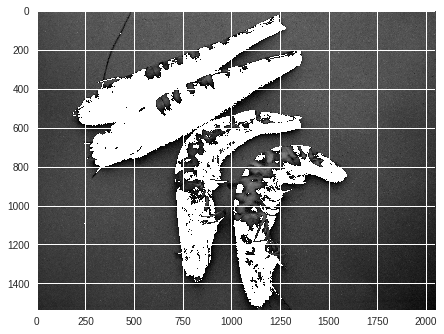

In [67]:
# Ejemplos de selección con mascara

import numpy as np


img_mask = image.flatten() #Aplana la imagen
img_mask[~binary.flatten()] = 255  #conversion de los FALSE de la imagen binaria en blanco(255)

img_mask= img_mask.reshape(image.shape) #colocación del array de línea a matriz



plt.imshow(img_mask, cmap=plt.cm.gray)

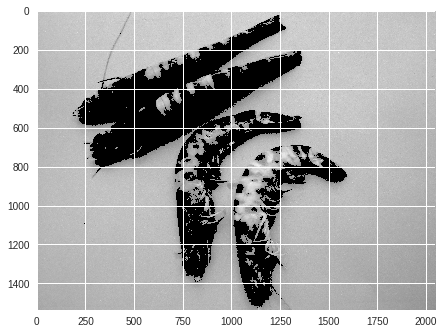

In [68]:
#Lo mismo que en la celda anterior pero convirtiendo el hombre a negro

img_mask = image.flatten()
img_mask[~binary.flatten()] = 0

img_mask= img_mask.reshape(image.shape)



plt.imshow(img_mask, cmap=plt.cm.gray)

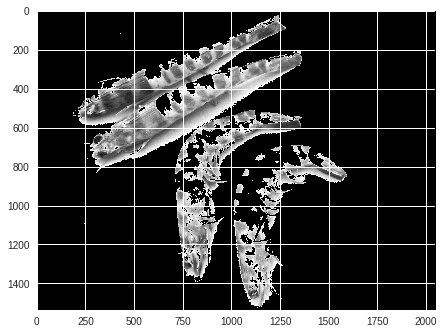

In [69]:
#Conversion del fondo a negro

img_mask = image.flatten()
img_mask[binary.flatten()] = 0

img_mask= img_mask.reshape(image.shape)



plt.imshow(img_mask, cmap=plt.cm.gray)

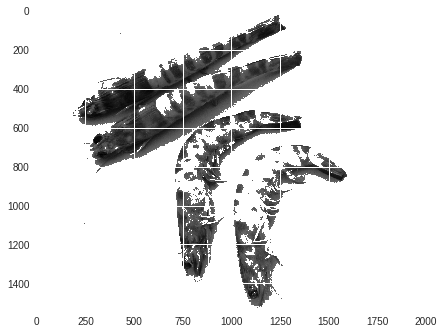

In [70]:
#Conversión del fondo a blanco

img_mask = image.flatten()
img_mask[binary.flatten()] = 255

img_mask= img_mask.reshape(image.shape)



plt.imshow(img_mask, cmap=plt.cm.gray)

Segmentación:

Algoritmo basado en watershed. Probaremos la implementación de skimage y de opencv a ver cual va mejor.


Watershed sobre-segmenta, esto es que da más segmentos de las gambas reales que están presentes en la imagen.
Para evitar esta sobre-segmentación cada una de las particiones posibles se evalua con el clasificador y si el clasificador dice que las dos partes son correctas es buena.

TODO: Improved pruning algoritm

In [14]:
# Empecemos a obtener características de cada imagen
'''
area, ojo, area ratio

http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

'''
# imports necesarios para hacer el análisis de componentes conexas
from skimage.measure import label
from skimage.measure import regionprops,find_contours

#Modulo para sacar los contornos que nos puede ser de utilidad posteriormente
fc=find_contours(img_mask, 0.5)
plt.imshow(img_mask, cmap=plt.cm.gray)

for region in regionprops(img_mask):
  print("____________________________________INICIO REGIONPROPS__________________________________")
  print("Área:",region.area) #Número de pixels de la region
  print("Eccentricity:",region.eccentricity)#Excentricidad de la elipse que tiene los mismos segundos segundos que la región. 
            #La excentricidad es la relación de la distancia focal (distancia entre los puntos focales)sobre la longitud del eje principal.
            #El valor está en el intervalo [0, 1). Cuando es 0, la elipse se convierte en un círculo
  print("Extent :",region.extent ) #Proporción de píxeles en la región a píxeles en el cuadro delimitador total. Calculado como área / (rows * cols)
  print("Solidity:",region.solidity) #Proporción de píxeles en la región a píxeles de la imagen del casco convexo
  



NameError: ignored

In [0]:
#Segmentacion de la imagen con el algoritmo watershed

from skimage.color import rgb2gray, rgb2grey

 



<ZipInfo filename='8.1.JPG' compress_type=deflate external_attr=0x20 file_size=957790 compress_size=947105>


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


<ZipInfo filename='8.3.JPG' compress_type=deflate external_attr=0x20 file_size=957228 compress_size=946882>
<ZipInfo filename='8.4.JPG' compress_type=deflate external_attr=0x20 file_size=991028 compress_size=981002>
<ZipInfo filename='8.7 - copia.JPG' compress_type=deflate external_attr=0x20 file_size=881596 compress_size=869887>
<ZipInfo filename='8.7.JPG' compress_type=deflate external_attr=0x20 file_size=881596 compress_size=869887>
<ZipInfo filename='8.8.jpg' compress_type=deflate external_attr=0x20 file_size=463365 compress_size=461399>
<ZipInfo filename='8.JPG' compress_type=deflate external_attr=0x20 file_size=963430 compress_size=952938>
<ZipInfo filename='10.1.JPG' compress_type=deflate external_attr=0x20 file_size=1190402 compress_size=1180259>
<ZipInfo filename='10.JPG' compress_type=deflate external_attr=0x20 file_size=1270303 compress_size=1269468>
<ZipInfo filename='4.1.JPG' compress_type=deflate external_attr=0x20 file_size=1229320 compress_size=1219333>
<ZipInfo filenam

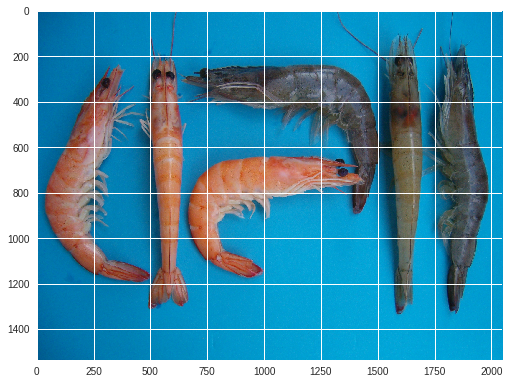

In [10]:
ls

datalab/    M_12.1.jpg  M_1.9.jpg  M_6.jpg    M_8.jpg
M_10_1.jpg  M_12.jpg    M_22.jpg   M_8.1.jpg  M_9.1.jpg
M_10.jpg    M_13.JPG    M_4.1.jpg  M_8.2.jpg  M_9.jpg
M_1.11.jpg  M_1.8.jpg   M_6.1.jpg  M_8.3.jpg  Melanosis.zip


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


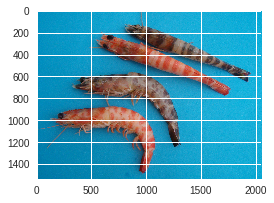

In [20]:
imge=leer_mostrar_imagen('4.1.JPG')

In [20]:
np.unique(markers)

array([-1,  1,  2,  3,  4], dtype=int32)

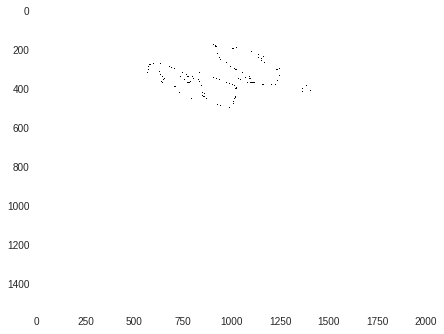

In [54]:
plt.imshow(markers==-1)


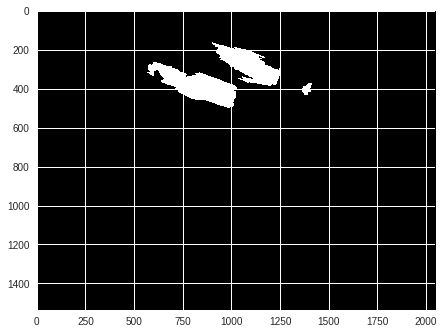

In [55]:
plt.imshow(markers==1)


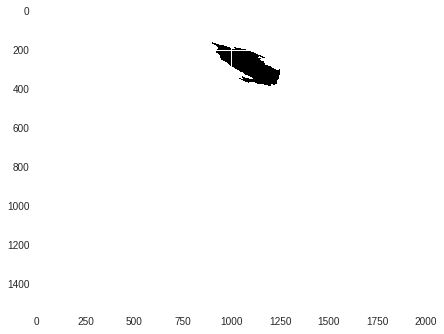

In [56]:
plt.imshow(markers==2)


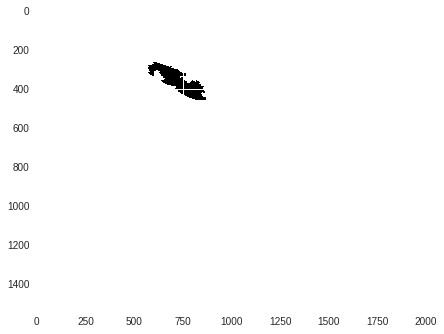

In [57]:
plt.imshow(markers==5)


______________________________________________________________________________________________________________________________________________________________________________________________

- probar a importar desde github (solo probar, sino te sale me escribes https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab)

- hacer funciones individuales:
  - escalaGrises
  - binarizar
  - ...
  
  Probar con skimage y opencv y quedarnos con la mas sencilla  

- hacer pruebas de skeleton con las imagenes de prueba de skimage, para ver si tiene que ser negro sobre blanco o blanco sobre negro (implementar si hace falta una función de invertir)

- binarizar bien la imagen para poder llevarla a skeleton
- probar skeleton con cv2 y con scikit
- comprobar markers



#Descarga y descomprime las imágenes de prueba


In [0]:
#Función que descarga un archivo de internet
def descargar_zip_url(url):
  from urllib import request
  import zipfile

  # Nombre del archivo a partir del URL
  zipname = url[url.rfind("/") + 1:]
  while not zipname:
    zipname = raw_input("No se ha podido obtener el nombre del ""archivo.\nEspecifique uno: ")

  print("Descargando..." ,zipname)

  # Archivo local
  z = open(zipname, "wb")

  # Escribir en un nuevo fichero local los datos obtenidos via HTTP.
  z.write(request.urlopen(url).read())

  # Cerrar ambos
  z.close()

  print ("Descargado correctamente.",zipname)

  print (zipname, zipfile.is_zipfile(zipname))
  return zipname

In [0]:
# abre y extrae todos los ficheros en un zip  
def extraer_zip(zipname):
  import zipfile
  password = None
  z = zipfile.ZipFile(zipname, "r")
  try:
      z.extractall(pwd=password)
      for file in z.namelist():
        print(z.getinfo(file))
        imshow(file)
  except:
      print('Error')
      pass
  z.close()

Descargando... Melanosis.zip
Descargado correctamente. Melanosis.zip
Melanosis.zip True
<ZipInfo filename='M_1.8.jpg' compress_type=deflate external_attr=0x20 file_size=889857 compress_size=885966>


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


<ZipInfo filename='M_1.9.jpg' compress_type=deflate external_attr=0x20 file_size=898450 compress_size=894857>
<ZipInfo filename='M_1.11.jpg' compress_type=deflate external_attr=0x20 file_size=873257 compress_size=868678>
<ZipInfo filename='M_4.1.jpg' compress_type=deflate external_attr=0x20 file_size=543103 compress_size=541010>
<ZipInfo filename='M_6.1.jpg' compress_type=deflate external_attr=0x20 file_size=910118 compress_size=892158>
<ZipInfo filename='M_6.jpg' compress_type=deflate external_attr=0x20 file_size=892746 compress_size=874270>
<ZipInfo filename='M_8.1.jpg' compress_type=deflate external_attr=0x20 file_size=1876783 compress_size=1870744>
<ZipInfo filename='M_8.2.jpg' compress_type=deflate external_attr=0x20 file_size=1951413 compress_size=1946739>
<ZipInfo filename='M_8.3.jpg' compress_type=deflate external_attr=0x20 file_size=1938843 compress_size=1933701>
<ZipInfo filename='M_8.jpg' compress_type=deflate external_attr=0x20 file_size=518408 compress_size=516281>
<ZipInf

Error


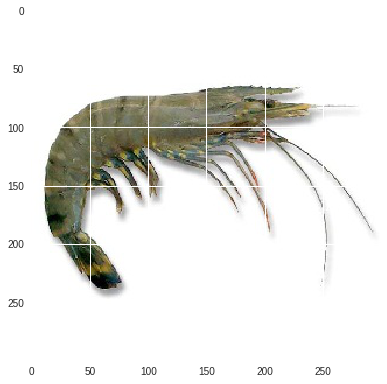

In [5]:
zipname=descargar_zip_url("https://github.com/apj0007/PrawnView/raw/master/docs/img/Melanosis.zip")
extraer_zip(zipname)

zipname=descargar_zip_url("https://github.com/apj0007/PrawnView/raw/master/docs/img/FOTOS%20TALLAS.zip")
extraer_zip(zipname)

zipname=descargar_zip_url("https://github.com/apj0007/PrawnView/raw/master/docs/img/Pareja.zip")
extraer_zip(zipname)

zipname=descargar_zip_url("https://github.com/apj0007/PrawnView/raw/master/docs/img/ind_internet.zip")
extraer_zip(zipname)

zipname=descargar_zip_url("https://github.com/apj0007/PrawnView/raw/master/docs/img/im_3.zip")
extraer_zip(zipname)

In [11]:
!ls

10.1.JPG  6.3.JPG	   c.png	       M_12.1.jpg  M_8.jpg
10.JPG	  6.4.JPG	   datalab	       M_12.jpg    M_9.1.jpg
1_1.jpg   6.7.JPG	   d.png	       M_13.JPG    M_9.jpg
1_2.jpg   8.1.JPG	   e.png	       M_1.8.jpg   Melanosis.zip
1_3.jpg   8.3.JPG	   FOTOS%20TALLAS.zip  M_1.9.jpg   Pareja.zip
1_4.jpg   8.4.JPG	   f.png	       M_22.jpg    PrawnView
1.jpg	  8.7 - copia.JPG  g.png	       M_4.1.jpg   x2.JPG
2_1.png   8.7.JPG	   im_3.zip	       M_6.1.jpg   x5.JPG
4.1.JPG   8.8.jpg	   ind_internet.zip    M_6.jpg	   x6.JPG
4.2.JPG   8.JPG		   M_10_1.jpg	       M_8.1.jpg   x7.1.JPG
4.JPG	  a.png		   M_10.jpg	       M_8.2.jpg   x7.JPG
6.2.JPG   b.png		   M_1.11.jpg	       M_8.3.jpg


#Emininar_ruido --- erosionar --base1 --pixelRGB2LAB

In [0]:
def elimina_ruido(grey):
  greym = ndimage.gaussian_filter(grey, 2)
  
  return greym


In [0]:
def erosionar(grey): 
  #grey=ndimage.binary_dilation(grey, structure=np.ones((2,2))).astype(grey.dtype) es con scikit
  kernel = np.ones((5,5), np.uint8)
  img_erosion = cv2.erode(grey, kernel, iterations=1)
  
  return img_erosion

In [0]:
'''
Función que transforma un número en base 255 en otro en base 1.
'''

def base1(num):
    valorEnBase255 = num
    valorEnBase1 = (valorEnBase255/255)*1
    return valorEnBase1

'''
Función para pasar un pixel de RGB a CIELAB

CIELAB es más apropiado para hacer diferencia de colores
'''
def pixelRGB2LAB(pixel):
    r,g,b = pixel # pixel es una lista con 3 valores, los puedo guardar en 3 variables asi
    rBase1 = base1(r)
    gBase1 = base1(g)
    bBase1 = base1(b)
    
    
    # rgb2lab espera una lista3D, así que le paso el pixel dentro 
    # de una lista de listas y para sacarlo igual.
    return rgb2lab([[[rBase1,gBase1,bBase1]]])[0][0]

#Muestra_imagenes

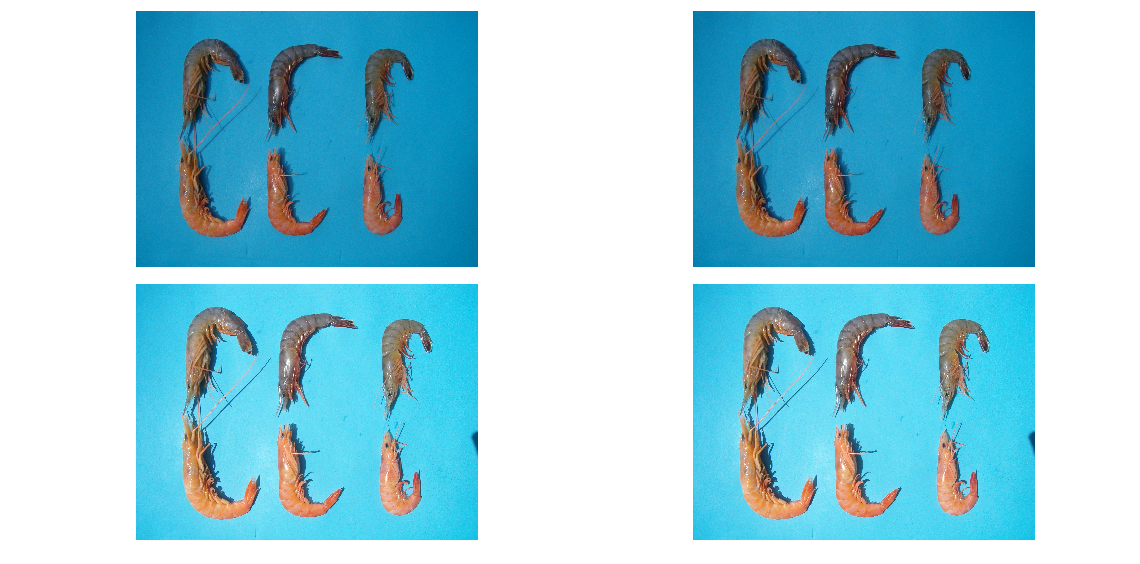

In [13]:
#Para visualizar las imágenes en tamaño mas grande se añade el parámetro grande=True
def muestra_imagenes(imagenes,grandes=False):
  num_images = len(imagenes)
  if num_images<2:
    print("Se debe pasar más de una imagen")
    return 0
  if grandes:
    c=round(num_images/2)
    fig, num_images = plt.subplots(nrows=c, ncols=2, figsize=(16, 8), sharex=True, sharey=True)
    ax = num_images.ravel()
    for i in range(len(imagenes)):
      ax[i].imshow(imagenes[i], cmap=plt.cm.gray, interpolation='nearest')
      ax[i].axis('off')

    fig.tight_layout()
    plt.show()

    return
  lado = math.ceil(num_images**0.1)
  tam_image = 7
  
  for i in range(len(imagenes)):
    plt.subplot(lado,lado,i+1)
    io.imshow(imagenes[i],cmap=plt.cm.gray)
  
 
  io.show()
  
  
# ojo a que existan las imagenes
img1 = imread('6.2.JPG')
img2 = imread('6.3.JPG')
img3 = imread('6.4.JPG')


muestra_imagenes([img2, img2, img3,img3],True)



In [0]:
def leer_mostrar_imagen(file,debug=False):

  img =imread(file)
  plt.subplot(211)
  io.imshow(img)
  return img

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


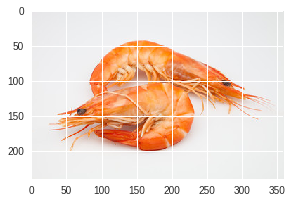

In [22]:
img4=leer_mostrar_imagen('4.1.JPG',True)
img1=leer_mostrar_imagen('1_2.jpg',True)
img1_1=leer_mostrar_imagen('1_1.jpg',True)
img1_3=leer_mostrar_imagen('1_3.jpg',True)
img2_1=leer_mostrar_imagen('2_1.png',True)

# Escaladegrises (de momento mejor opción escala_grises1() )

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


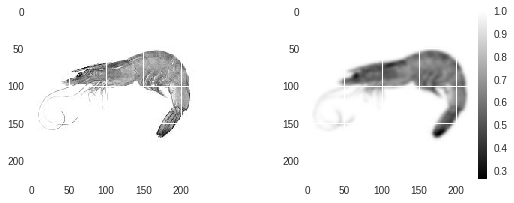

In [45]:
def escala_grises1(img, mostrar=False):
  
  img = color.rgb2gray(img)
  img_gris=elimina_ruido(img)
  if mostrar:
    muestra_imagenes([img, img_gris])
  
  return img_gris

gray1=escala_grises1(img1, mostrar=True)# lo devuelve en 1 y 0


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


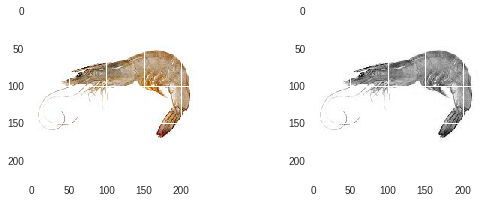

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [36]:
def escala_grises2(img,debug=False): 
  img_gris= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #Imagen en 2D escala de grises para trabajar con ella
  if debug:
    muestra_imagenes([img, img_gris])
   
  return img_gris


'''
Problemas con este ejemplo.
1 Definir si el fondo va a ser más claro o más oscuro que el langostino
2 Usar diferencia de color con el color prototipico del langostino

'''
gray2=escala_grises2(img1,debug=True) # lo devuelve en 255 y 0
gray2

In [37]:
'''
Mira más abajo el resultado de binarizar gray3

Idea 1: En lugar de hacer la diferencia contra un color (anaranjado) se podría hacer contra varios tonos que puedan tener los langostinos
Idea 2: En lugar de comparar contra colores de langostino, comparar contra colores de fondo, ya que lo podriamos controlar
Con la idea 1 lo que fuese langostino sería oscuro en la imagen de salida
Con la idea 2 lo que fuese fondo sería oscuro en la imagen de salida

'''
def escala_grises3(img,color, debug=False): 
  imagenLab = rgb2lab(img)
  colorLab = pixelRGB2LAB(color)
  img_gris = abs(imagenLab-color).mean(axis=2)/255
  if debug:
    muestra_imagenes([img, img_gris])
    
  return img_gris

gray3=escala_grises3(img4,[247,211,114],debug=True)
#gray3=escala_grises3(imge,[247,211,114],debug=True) 
#gray3 = escala_grises3(img1,[255,255,255],debug=True) 

gray3

NameError: ignored

# Binarizar

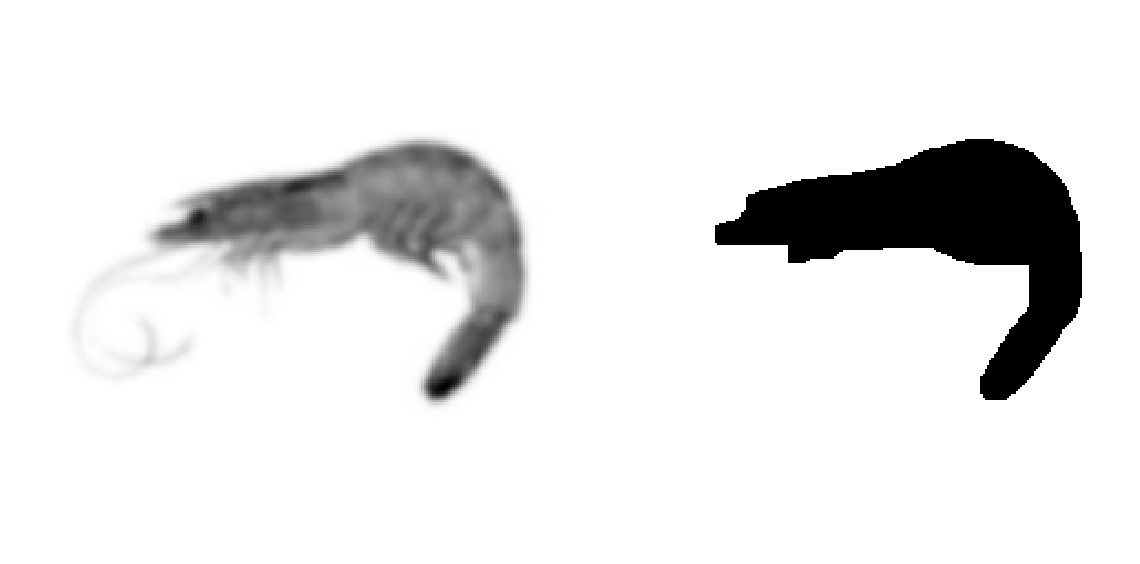

In [46]:
#Si se desea imprimir la imagen se debe enviar True

def binarizar(gray,mostrar=False):
  thresh = threshold_otsu(gray)
  binary = gray > thresh
  
  
  binary=op_morfologicas(binary)
  
  
  if mostrar:
    muestra_imagenes([gray, binary],True)
  
  return binary

binary1=binarizar(gray1,True)


In [0]:
def op_morfologicas(binary):
  from skimage.morphology import closing, opening, erosion, dilation
  from skimage.morphology import square
  binary = dilation(binary, square(7))
  binary = opening(binary, square(25))  
  binary = erosion(binary, square(8))
  
  return binary

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


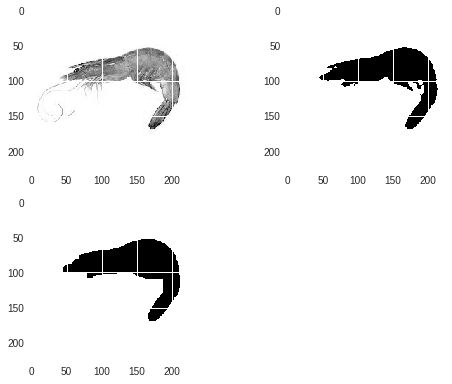

In [65]:
def binarizar2(gray):
  #grey=eliminaruido(gray)
  #ret,binary = cv2.threshold(gray,190,255,cv2.THRESH_BINARY)
  
  blur = cv2.GaussianBlur(gray,(5,5),0)
  ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  
  binary=op_morfologicas(th3)
  
  #th4=dilatar_apertura(th3)
  
  muestra_imagenes([gray,th3,binary])
  return binary

binary2=binarizar2(gray2)



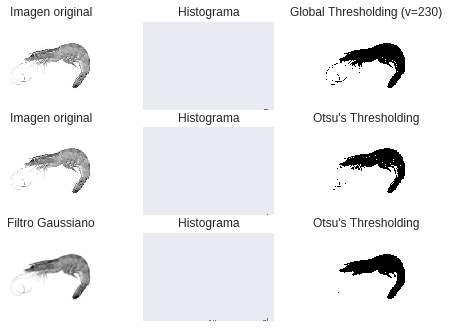

In [19]:
def xrange(x):

    return iter(range(x))

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('1_2.jpg',0)
# global thresholding
ret1,th1 = cv.threshold(img,230,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Imagen original','Histograma','Global Thresholding (v=230)',
          'Imagen original','Histograma',"Otsu's Thresholding",
          'Filtro Gaussiano','Histograma',"Otsu's Thresholding"]
for i in xrange(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [79]:
binary

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [28]:
from skimage.morphology import closing, opening, erosion, dilation
from skimage.morphology import square
binary = dilation(th3, square(7))
binary = opening(th3, square(25))

NameError: ignored

In [80]:
muestra_imagenes(binary,th3)

TypeError: ignored

# invertirbinarizar

In [0]:
def invertirbinarizar1(binary):
  inbin = util.invert(binary)
  muestra_imagenes([binary,inbin])
  return inbin

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


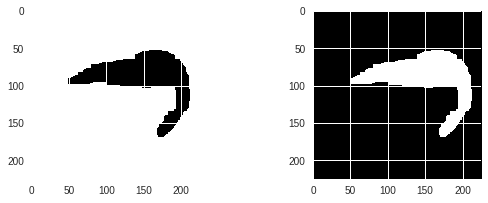

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [56]:
inbin1=invertirbinarizar1(binary1)
inbin1

In [57]:
def invertirbinarizar2(binary):
  ret,thresh2 = cv2.threshold(binary,220,255,cv2.THRESH_BINARY_INV)
  muestra_imagenes([binary,thresh2])
  return thresh2

inbin2=invertirbinarizar2(binary1)
inbin2

TypeError: ignored

In [110]:
inbin2


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

# Skeleton

In [0]:
'''
Poner el nombre correcto al parametro

'''
def skeleton1(data,is_binary=False):
  from skimage.util import invert
  from skimage.data import binary_blobs
  if is_binary:
    data = invert(data)
  #data = binary_blobs(200, blob_size_fraction=.2, volume_fraction=.35, seed=1)
  
  skeleton3d = skeletonize_3d(data)
  '''
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharex=True, sharey=True)

  ax = axes.ravel()

  ax[0].imshow(data, cmap=plt.cm.gray, interpolation='nearest')
  ax[0].set_title('Langostino')
  ax[0].axis('off')

  ax[1].imshow(skeleton3d, cmap=plt.cm.gray, interpolation='nearest')
  ax[1].set_title('Función skeletonize_3d')
  ax[1].axis('off')

  fig.tight_layout()
  plt.show()
  '''
  muestra_imagenes([data,skeleton3d],True)
  
  return skeleton3d



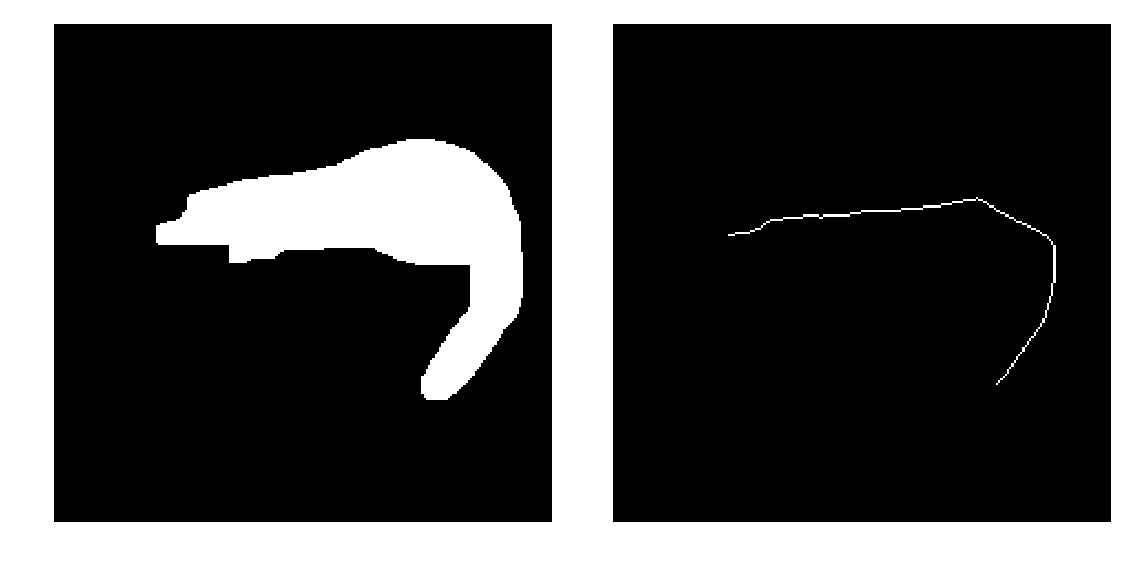

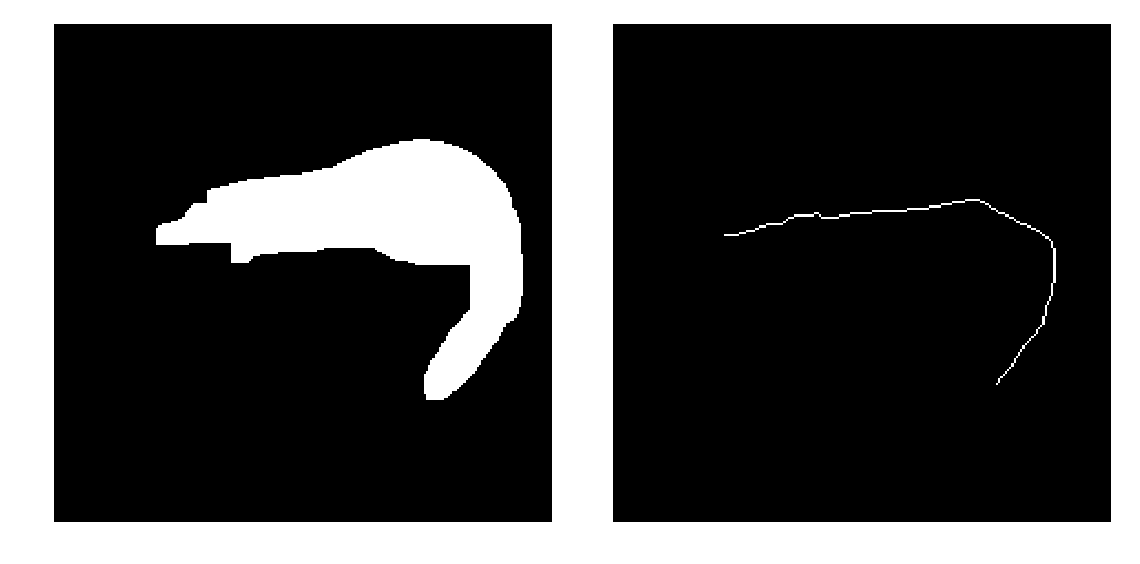

In [69]:
#Si esnviamos imagen binaria se le añade el parámetro True
sk1 = skeleton1(binary1,True)
sk2 = skeleton1(binary2,True)

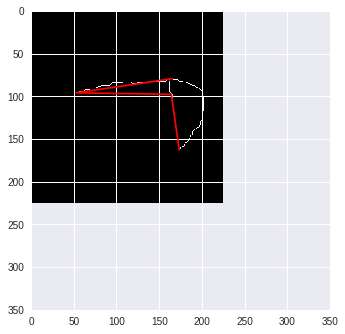

(array([[ 81, 161],
        [ 95,  54],
        [102, 165],
        [162, 174]]), array([[ 79.35064061, 165.51752391],
        [ 96.0032579 ,  53.01399151],
        [ 97.75903558, 164.21646934],
        [162.67132052, 173.39243645]]))

In [76]:
from matplotlib import pyplot as plt

from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse




coords = corner_peaks(corner_harris(sk), min_distance=5)
coords_subpix = corner_subpix(sk, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(sk, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], '.b', markersize=3)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], 'r', markersize=25)
ax.axis((0, 350, 350, 0))
plt.show()


coords, coords_subpix

# Segmentación


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


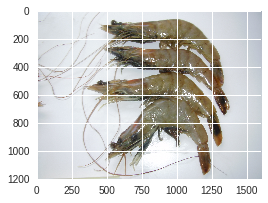

In [98]:
imgep=leer_mostrar_imagen( 'M_4.1.jpg')

In [0]:
def segmentacion(img):
  
  import numpy as np
  import cv2
  from matplotlib import pyplot as plt

  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  
  # noise removal
  kernel = np.ones((3,3),np.uint8)
  opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

  # sure background area
  sure_bg = cv2.dilate(opening,kernel,iterations=3)

  # Finding sure foreground area
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
  ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)
  
  # Marker labelling
  ret, markers = cv2.connectedComponents(sure_fg)

  # Add one to all labels so that sure background is not 0, but 1
  markers = markers+1

  # Now, mark the region of unknown with zero
  markers[unknown==255] = 0
  
  markers = cv2.watershed(img,markers)
  img[markers == -1] = [255,0,0]
  
  return markers



In [0]:
markers=segmentacion(imgep)

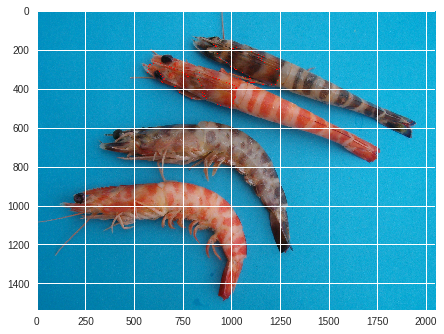

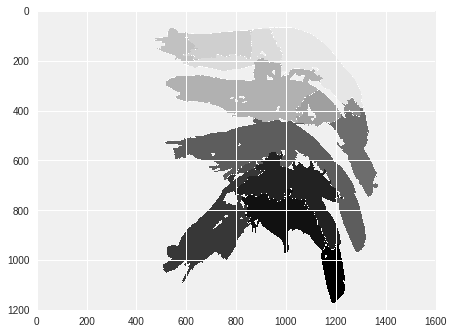

In [102]:
plt.imshow(imge)
plt.figure()
plt.imshow(markers)

In [0]:
 def a(image): 
  import numpy as np
  import matplotlib.pyplot as plt
  from scipy import ndimage as ndi

  from skimage.morphology import watershed
  from skimage.feature import peak_local_max
  
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  ret, image = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)



  # Now we want to separate the two objects in image
  # Generate the markers as local maxima of the distance to the background
  distance = ndi.distance_transform_edt(image)
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                              labels=image)
  markers = ndi.label(local_maxi)[0]
  labels = watershed(-distance, markers, mask=image)

  fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
  ax = axes.ravel()

  ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
  ax[0].set_title('Overlapping objects')
  ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
  ax[1].set_title('Distances')
  ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
  ax[2].set_title('Separated objects')

  for a in ax:
      a.set_axis_off()

  fig.tight_layout()
  plt.show()

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


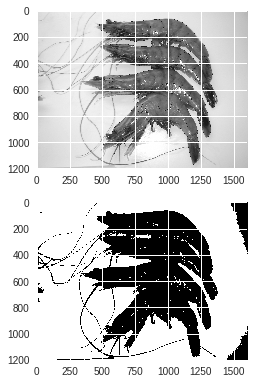

NameError: ignored

In [88]:
gray1p=escaladegrises2(imgep)
binary1p=binarizar2(gray1p)
inbin1p=invertirbinarizar2(binary1p)

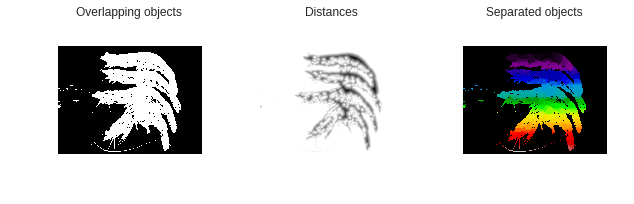

In [201]:
a(imgep)

*texto en cursiva*- Buscar librerias para hacer gui (qt, wxwidgets, kiwy y lo que haya nuevo, elegir la más facil)
- Conseguir imagenes propias
- Binarizar ojo/melanosis
- Calibrar tus parametros
- Hacer pruebas y documentarlas


JF
- Mirar lo de http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html
- Hacer un miniprototipo para descartar los segmentos erroneos

# Detección ojo

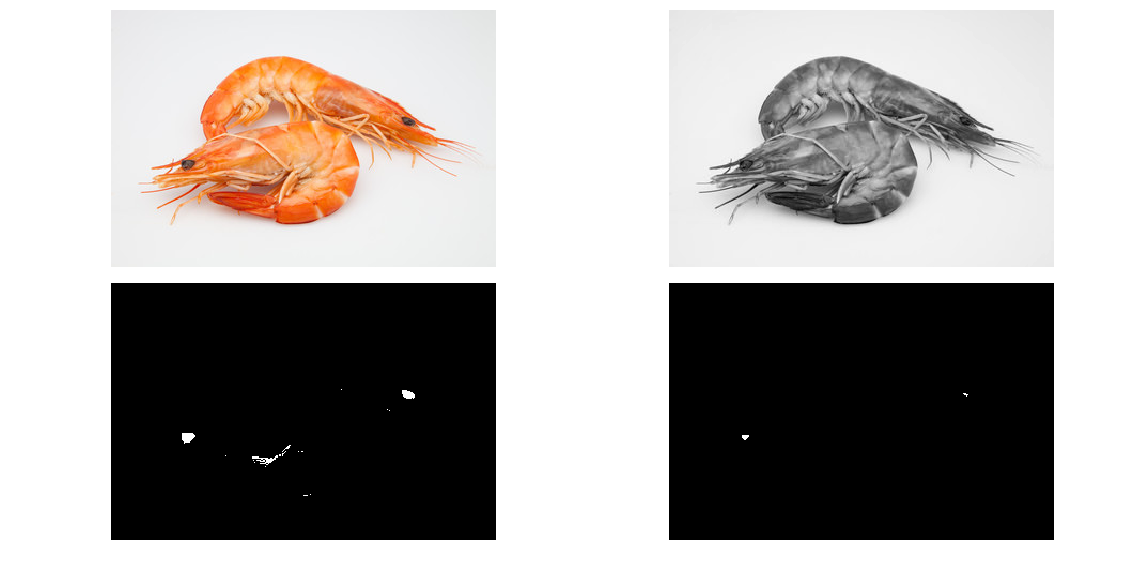

In [27]:

def deteccion_ojo(frame):



  img_gray= cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
  hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) #Convertir a HSV

  #array con las posiciones min - max
  lower=np.array([0,0,0])
  upper=np.array([255,255,150])

  #Deteccion de colores
  mask = cv2.inRange(hsv, lower, upper)

  #Erosion de la imagen
  kernel = np.ones((5,5),np.uint8) 
  Erosion = cv2.erode(mask,kernel,iterations = 1)

  
  muestra_imagenes([frame,img_gray,mask,Erosion],True)





    
    
deteccion_ojo(img2_1)

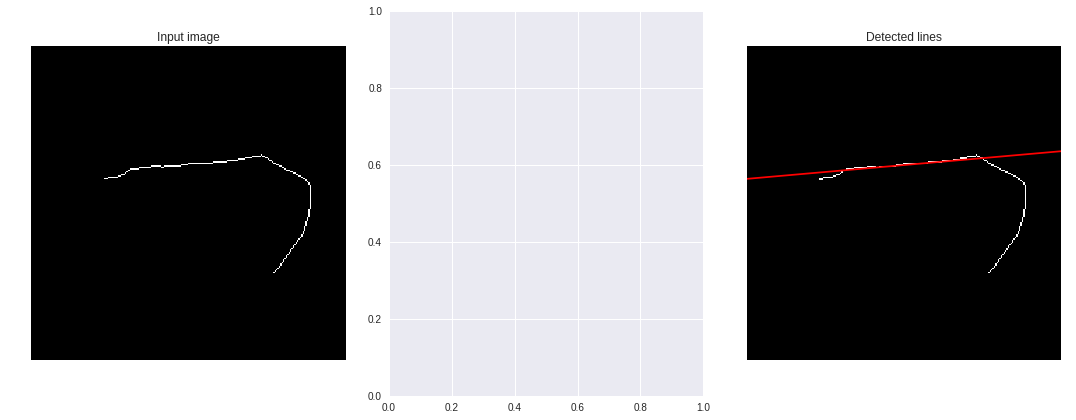

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


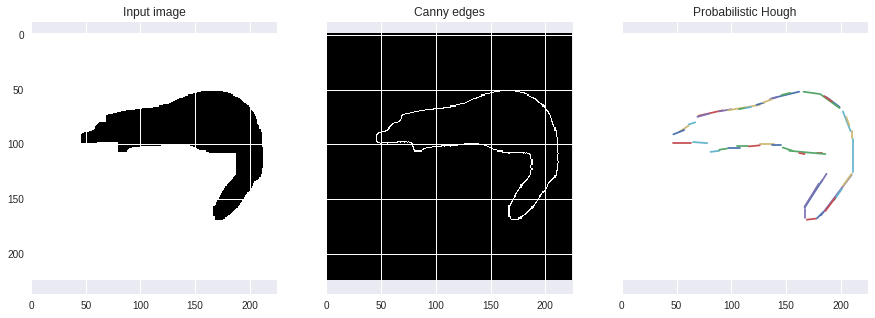

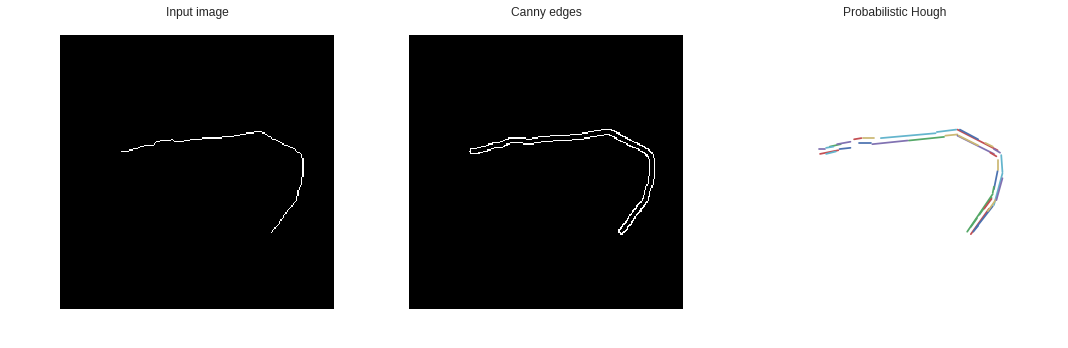

In [70]:
from skimage.transform import (hough_line, hough_line_peaks,probabilistic_hough_line)
from matplotlib import cm


/usr/local/lib/python3.6/dist-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


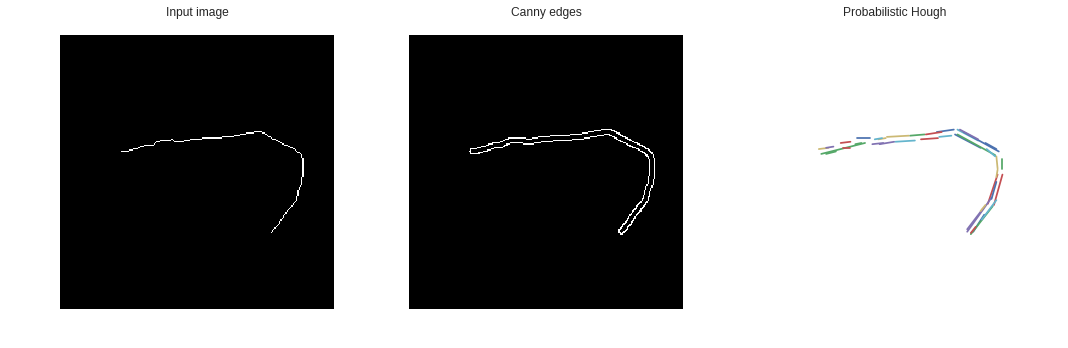

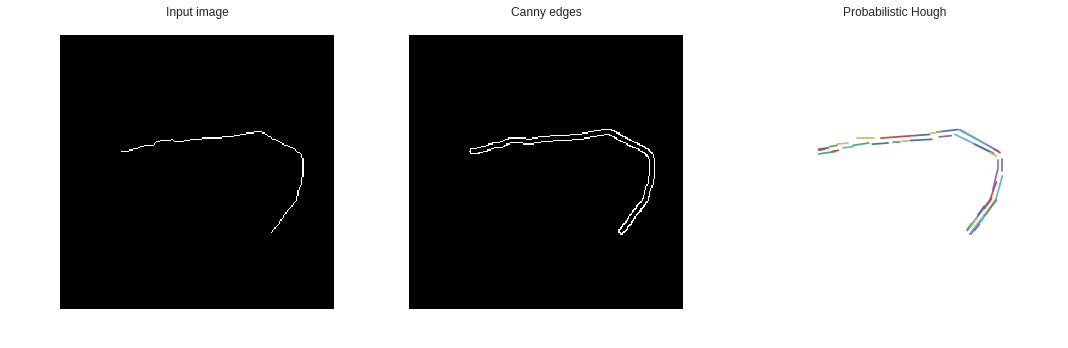

In [82]:
def Probabilistic(image):
  from skimage.transform import (hough_line, hough_line_peaks,probabilistic_hough_line)
  from matplotlib import cm
  from skimage.feature import canny
  

  # Line finding using the Probabilistic Hough Transform
  image = sk2
  edges = canny(image, 2, 1, 25)
  lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                   line_gap=3)

  # Generating figure 2
  fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
  ax = axes.ravel()

  ax[0].imshow(image, cmap=cm.gray)
  ax[0].set_title('Input image')

  ax[1].imshow(edges, cmap=cm.gray)
  ax[1].set_title('Canny edges')

  ax[2].imshow(edges * 0)
  for line in lines:
      p0, p1 = line
      ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
  ax[2].set_xlim((0, image.shape[1]))
  ax[2].set_ylim((image.shape[0], 0))
  ax[2].set_title('Probabilistic Hough')

  for a in ax:
      a.set_axis_off()

  plt.tight_layout()
  plt.show()
  
Probabilistic(sk1)
Probabilistic(sk2)

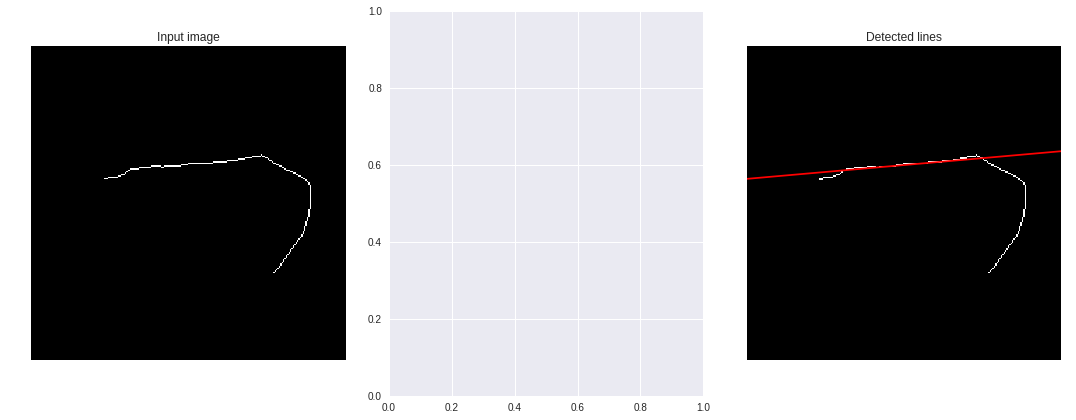

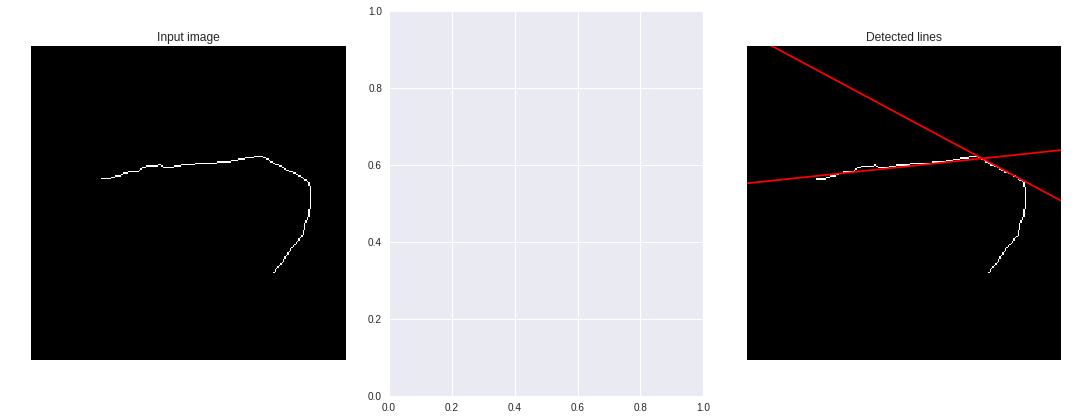

In [80]:
def classic(image):
  from skimage.transform import (hough_line, hough_line_peaks,probabilistic_hough_line)
  from matplotlib import cm

  # Classic straight-line Hough transform
  h, theta, d = hough_line(image)

  # Generating figure 1
  fig, axes = plt.subplots(1, 3, figsize=(15, 6))
  ax = axes.ravel()

  ax[0].imshow(image, cmap=cm.gray)
  ax[0].set_title('Input image')
  ax[0].set_axis_off()



  ax[2].imshow(image, cmap=cm.gray)
  for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
      y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
      y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
      ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
  ax[2].set_xlim((0, image.shape[1]))
  ax[2].set_ylim((image.shape[0], 0))
  ax[2].set_axis_off()
  ax[2].set_title('Detected lines')

  plt.tight_layout()
  plt.show()

classic(sk1)
classic(sk2)